# Import

In [401]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

sns.set_style("white")

# Read data

In [12]:
df_weights = pd.read_csv('/Users/mandyliu/Documents/R/geolift_weights.csv')  
df_markets = pd.read_csv('/Users/mandyliu/Documents/R/market_data.csv')  

In [18]:
df_weights.head()

,location,weight
0,atlanta,-2.836501e-09
1,baltimore,-7.680428e-11
2,baton rouge,6.408385e-03
3,boston,-3.210702e-09
4,chicago,2.981435e-10


In [22]:
df_markets.head()

,location,Y,date
0,new york,3300,2021-01-01
1,new york,3202,2021-01-02
2,new york,4138,2021-01-03
3,new york,3716,2021-01-04
4,new york,3270,2021-01-05


# Create synthetic control

In [35]:
# convert to pandas datetime
df_markets['date']=pd.to_datetime(df_markets['date'],format = '%Y-%m-%d')

In [57]:
# combine control markets with weights
df_markets_weights = df_markets.merge(df_weights, on='location')

In [71]:
df_markets_weights['weighted_Y'] = df_markets_weights['Y'] * df_markets_weights['weight']

In [73]:
df_markets_weights.head()

,location,Y,date,weight,weighted_Y
0,new york,3300,2021-01-01,1.892823e-10,6.246314e-07
1,new york,3202,2021-01-02,1.892823e-10,6.060818e-07
2,new york,4138,2021-01-03,1.892823e-10,7.832500e-07
3,new york,3716,2021-01-04,1.892823e-10,7.033729e-07
4,new york,3270,2021-01-05,1.892823e-10,6.189530e-07


In [260]:
# sum weighted_Y by date to create a single synthetic control city
df_syn_control = df_markets_weights.groupby('date').sum('weighted_Y')\
.reset_index()[['date','weighted_Y']].rename(columns = {'weighted_Y':'Y'})
df_syn_control['location'] = 'syn_control'

In [176]:
df_syn_control.head()

,date,Y,location
0,2021-01-01,2679.748528,syn_control
1,2021-01-02,2826.338109,syn_control
2,2021-01-03,3406.862723,syn_control
3,2021-01-04,2945.563602,syn_control
4,2021-01-05,2461.750731,syn_control


In [230]:
# append Austin data to syn control
df_markets_austin = df_markets[df_markets['location']=='austin'].reset_index(drop = True)

In [161]:
df_syn_control_austin = pd.concat([df_markets_austin,df_syn_control],ignore_index = True)

# Plot

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(array([18628., 18642., 18659., 18673., 18687., 18701., 18718.]),
 [Text(18628.0, 0, '2021-01-01'),
  Text(18642.0, 0, '2021-01-15'),
  Text(18659.0, 0, '2021-02-01'),
  Text(18673.0, 0, '2021-02-15'),
  Text(18687.0, 0, '2021-03-01'),
  Text(18701.0, 0, '2021-03-15'),
  Text(18718.0, 0, '2021-04-01')])

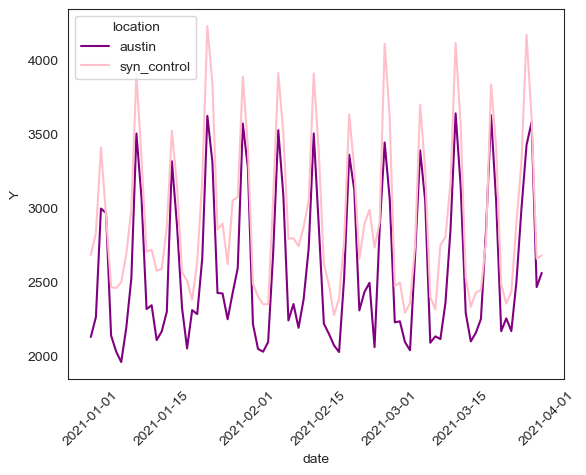

In [405]:
sns.lineplot(data=df_syn_control_austin, x="date", y="Y",hue = 'location',palette=['purple', 'pink'])
plt.xticks(rotation=45)

In [411]:
# Correlation
df_corr = df_syn_control[['date','Y']].merge(df_markets_austin[['date','Y']],on = 'date')
df_corr['Y_x'].corr(df_corr['Y_y'])

0.9503089926853345

# Measure lift

In [286]:
# create multiplier
austin_Y = df_markets_austin.loc[df_markets_austin['date']==df_markets_austin['date'].max(),'Y'].iloc[0]
syn_control_Y = df_syn_control.loc[df_syn_control['date']==df_syn_control['date'].max(),'Y'].iloc[0]

M = austin_Y/syn_control_Y

In [288]:
M

0.9556415990151904

### Create test data

In [296]:
# create two weeks' fake test data
df_markets_austin['date'].max()

Timestamp('2021-03-31 00:00:00')

In [333]:
# create a list of dates
date_list = []
start_date = df_markets_austin['date'].max()

k = 15
for day in range(1,k):
    date = start_date + timedelta(days=day)
    date_list.append(date)

date_list

[Timestamp('2021-04-01 00:00:00'),
 Timestamp('2021-04-02 00:00:00'),
 Timestamp('2021-04-03 00:00:00'),
 Timestamp('2021-04-04 00:00:00'),
 Timestamp('2021-04-05 00:00:00'),
 Timestamp('2021-04-06 00:00:00'),
 Timestamp('2021-04-07 00:00:00'),
 Timestamp('2021-04-08 00:00:00'),
 Timestamp('2021-04-09 00:00:00'),
 Timestamp('2021-04-10 00:00:00'),
 Timestamp('2021-04-11 00:00:00'),
 Timestamp('2021-04-12 00:00:00'),
 Timestamp('2021-04-13 00:00:00'),
 Timestamp('2021-04-14 00:00:00')]

In [369]:
# create fake austin data
data_austin_new = {
    "date":date_list, 
    "Y":   df_markets_austin.tail(14)['Y'].values*1.2, 
    "location":  ['austin'] * 14
}

In [371]:
df_austin_new = pd.DataFrame(data_austin_new)
df_markets_austin_test = pd.concat([df_markets_austin,df_austin_new])

In [373]:
# create fake synthetic control data 
data_syn_control_new = {
    "date":date_list, 
    "Y":   df_syn_control.tail(14)['Y'].values, 
    "location":  ['syn_control'] * 14
}

In [375]:
df_syn_control_new = pd.DataFrame(data_syn_control_new)
df_syn_control_test = pd.concat([df_syn_control,df_syn_control_new])

In [377]:
#adjust synthetic control with multiplier M
df_syn_control_adj = df_syn_control_test.copy()
df_syn_control_adj['Y'] = df_syn_control_adj['Y']*M

In [379]:
# combine austin and adjusted control data
df_syn_control_austin_adj = pd.concat([df_markets_austin_test,df_syn_control_adj]\
                                      ,ignore_index = True)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(array([18628., 18642., 18659., 18673., 18687., 18701., 18718., 18732.]),
 [Text(18628.0, 0, '2021-01-01'),
  Text(18642.0, 0, '2021-01-15'),
  Text(18659.0, 0, '2021-02-01'),
  Text(18673.0, 0, '2021-02-15'),
  Text(18687.0, 0, '2021-03-01'),
  Text(18701.0, 0, '2021-03-15'),
  Text(18718.0, 0, '2021-04-01'),
  Text(18732.0, 0, '2021-04-15')])

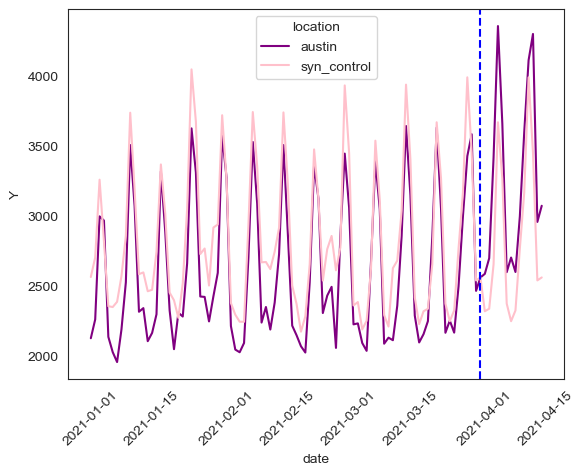

In [403]:
# plot austin fake test data and adjusted control
ax = sns.lineplot(data=df_syn_control_austin_adj, x="date", y="Y",hue = 'location',palette=['purple', 'pink'])
ax.axvline(x = date(2021,3,31),c='b', linestyle = "dashed")
plt.xticks(rotation=45)